In [1]:
import uproot
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from pathlib import Path

In [2]:
mcfile_path = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/dijet-mono-result/pythia/dijet_pythia_mono-a.root"
mcfile = uproot.open(mcfile_path)
datafile_path = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/dijet-mono-result/data/dijet_data_1516.root"
datafile = uproot.open(datafile_path)

In [3]:
label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
label_leadingtype = ["LeadingJet", "SubJet"]
label_etaregion = ["Forward", "Central"]
label_jettype = ["Quark", "Gluon", "B_Quark", "C_Quark", "Other"]
label_var = ["pt", "eta", "ntrk", "width", "c1", "bdt"]
n_bins_var = [60, 50, 60, 60, 60, 60]


In [4]:
Read_HistMap = {}
Read_HistMap_Error = {}

for i, jettype in enumerate(label_jettype):
    Read_HistMap[jettype] = np.zeros((n_bins_var[0]), dtype=float)
    Read_HistMap_Error[jettype] = np.zeros((n_bins_var[0]), dtype=float)
    for pt in label_ptrange[:-1]:
        for leadingtype in label_leadingtype[0:1]:
            for eta_region in label_etaregion: 
                Read_HistMap[jettype] += mcfile[f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]}"].to_numpy()[0]
                Read_HistMap_Error[jettype] += mcfile[f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]}_err"].to_numpy()[0]

In [5]:
Read_HistMap_Data = {}
Read_HistMap_Error_Data = {}
label_jettype_data = ["Data"]
for i, jettype in enumerate(label_jettype_data):
    Read_HistMap_Data[jettype] = np.zeros((n_bins_var[0]), dtype=float)
    Read_HistMap_Error_Data[jettype] = np.zeros((n_bins_var[0]), dtype=float)
    for pt in label_ptrange[:-1]:
        for leadingtype in label_leadingtype[0:1]:
            for eta_region in label_etaregion: 
                Read_HistMap_Data[jettype] += datafile[f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]}"].to_numpy()[0]
                Read_HistMap_Error_Data[jettype] += datafile[f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]}_err"].to_numpy()[0]

In [6]:
MC_jet_types = ['C_Quark', 'B_Quark', 'Gluon', 'Quark']
MC_jets = []
for MC_jet_type in MC_jet_types:
    MC_jets.append(Read_HistMap[MC_jet_type])

MC_jets = np.array(MC_jets)
cumsum_MC_jets = np.cumsum(MC_jets, axis = 0)
cumsum_MC_jets = np.concatenate((np.zeros((n_bins_var[0]), dtype=float)[None,:], cumsum_MC_jets))

In [7]:
total_error = np.zeros(60, dtype=np.float32)
for mc_type in MC_jet_types[1:]:
    total_error += Read_HistMap_Error[mc_type]

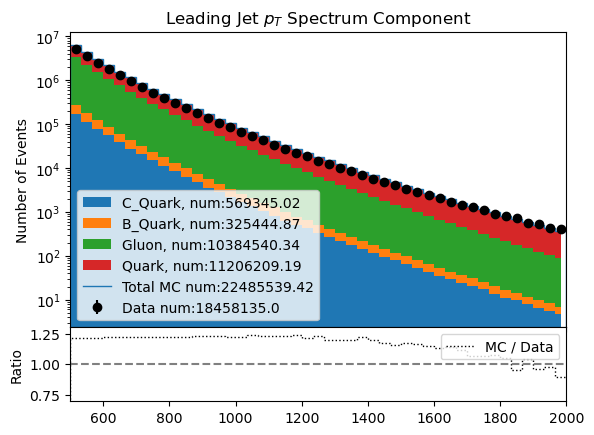

In [8]:
fig, (ax, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
custom_bins = np.linspace(0, 2000, 61)
pt_bin_centers = 1/2 * (custom_bins[:-1] + custom_bins[1:])

for i in range(0, len(MC_jet_types)):
    ax.fill_between(pt_bin_centers, cumsum_MC_jets[i], cumsum_MC_jets[i+1], label = MC_jet_types[i]+ f", num:{np.sum(MC_jets[i]):.2f}", step='mid')

ax.stairs(values=cumsum_MC_jets[-1], edges=custom_bins, label = "Total MC"+ f" num:{np.sum(cumsum_MC_jets[-1]):.2f}" )
ax.errorbar(pt_bin_centers, Read_HistMap_Data['Data'], yerr= np.sqrt(Read_HistMap_Error_Data["Data"]) , color= "black", linestyle='', marker= "o", label = "Data" + f" num:{np.sum(Read_HistMap_Data['Data'])}")

with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.true_divide(cumsum_MC_jets[-1], Read_HistMap_Data['Data'])
    ratio[ratio == np.inf] = 0
    ratio = np.nan_to_num(ratio)

ax1.stairs(values = ratio, edges=custom_bins, color = "black", linestyle=':', label = 'MC / Data', baseline=None)
ax1.hlines(y = 1, xmin = 500, xmax = 2000, color = 'gray', linestyle = '--')
ax1.set_ylabel("Ratio")
ax1.set_ylim(0.7, 1.3)
ax.set_yscale('log')
ax.set_xlim(500, 2000)
ax.set_title( 'Leading Jet $p_{T}$ Spectrum Component')
ax.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel('Number of Events')
ax.legend()
ax1.legend()
fig.show()